In [2]:
from matplotlib import pyplot as plt
import numpy as np
import gym
from numpy import int8
from keras.layers import Dense
from keras.models import Sequential, load_model
from keras.optimizers import Adam

In [3]:
class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions, discrete=True):
        self.mem_size = max_size
        self.mem_counter = 0
        self.discrete = discrete
        self.state_memory = np.zeros((self.mem_size, input_shape[0]))
        self.new_state_memory = np.zeros((self.mem_size, input_shape[0]))
        dtype = np.int32 if self.discrete else np.float32
        self.action_memory = np.zeros((self.mem_size, n_actions), dtype=dtype)
        self.reward_memory = np.zeros(self.mem_size)

        self.terminal_memory = np.zeros(self.mem_size, dtype=np.float32)

    def Store_Transition(self, state, new_state, action, reward, done):
        index = self.mem_counter % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = new_state
        if self.discrete:
            # in DQN the actions are discrete and there are limited number of them
            # in this case we represent the action in binary and the corresponding action is flaged as 1 in binary format
            actions = np.zeros(self.action_memory.shape[1])
            actions[action] = 1.0
            self.action_memory[index] = actions
        else:
            self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = 1 - int(done)
        self.mem_counter += 1

    def Sample_Buffer(self, batch_size):
        number_of_stored_indicies = min(self.mem_counter, self.mem_size)
        batch = np.random.choice(number_of_stored_indicies, batch_size)
        states = self.state_memory[batch]
        new_states = self.new_state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        terminals = self.terminal_memory[batch]

        return states, new_states, actions, rewards, terminals


In [4]:
class Network(object):
    def __init__(self, learning_rate, input_dims, fc1_dims, fc2_dims, n_actions):
        self.lr = learning_rate
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions

    def Build(self):
        model = Sequential(
            [Dense(units=self.fc1_dims, activation='relu', input_shape=self.input_dims),
             Dense(units=self.fc2_dims, activation='relu'),
             Dense(units=self.n_actions)]
        )
        model.compile(optimizer=Adam(learning_rate=self.lr), loss='mse')
        model.summary()

        return model

In [5]:


class Agent(object):
    def __init__(self, alpha, gamma, n_actions, epsilon, batch_size,
                 input_dims, epsilon_dec=0.996, min_epsilon=0.01,
                 mem_size=1000000, fname='ddqn_model.h5', replace_target=100):
        self.alpha = alpha
        self.gamma = gamma
        self.n_actions = n_actions
        self.action_space = [i for i in range(self.n_actions)]
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.input_dims = input_dims
        self.epsilon_dec = epsilon_dec
        self.min_epsilon = min_epsilon
        self.memory = ReplayBuffer(mem_size, input_dims, n_actions, True)
        self.fname = fname
        self.replace_target = replace_target
        _network = Network(
            alpha, input_dims, 256, 256, n_actions)
        self.q_network = _network.Build()
        self.target_network = _network.Build()

    def AddToMemory(self, state, action, reward, new_state, done):
        self.memory.Store_Transition(state, new_state, action, reward, done)

    def Policy(self, state):
        state = state[np.newaxis, :]
        rand_number = np.random.random()
        if rand_number < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            actions = self.q_network.predict(state)
            action = np.argmax(actions)

        return action

    def Learn(self):
        if self.memory.mem_counter % self.batch_size == 0 and self.memory.mem_counter != 0:
            states, new_states, actions, rewards, terminals = self.memory.Sample_Buffer(
                self.batch_size)
            action_values = np.array(self.action_space, dtype=np.int8)
            action_indicies = np.dot(actions, action_values)

            q_next = self.target_network.predict(new_states)
            q_eval = self.q_network.predict(new_states)

            q_pred = self.q_network.predict(states)

            max_actions = np.argmax(q_eval, axis=1)
            q_target = q_pred

            # batch_index = np.arange(self.batch_size, dtype=np.int32)
            for i in range(self.batch_size):
                q_target[i, int(action_indicies[i])] = rewards[i] + \
                    self.gamma * q_next[i, int(max_actions[i])]*terminals[i]

            # q_target[batch_index , action_indicies] = rewards + self.gamma * q_next[batch_index , max_actions.astype(int)]*terminals
            self.q_network.fit(states, q_target, verbose=0)

            self.epsilon = self.epsilon * \
                self.epsilon_dec if self.epsilon > self.min_epsilon else self.min_epsilon

            if self.memory.mem_counter % self.replace_target == 0:
                self.update_network_weights()

    def update_network_weights(self):
        self.target_network.set_weights(self.q_network.get_weights())

    def save_model(self):
        self.q_network.save(self.fname)

    def load_model(self):
        self.q_network = load_model(self.fname)

        if self.epsilon <= self.min_epsilon:
            self.update_network_weights()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2304      
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 69124 (270.02 KB)
Trainable params: 69124 (270.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               2304      
                                                              

2023-12-16 23:35:36.676207: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-16 23:35:36.676943: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/sobi/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


2/2 [==============================] - 0s 2ms/step
episode:  0 reward:  -70.30152216757688 average reward:  -70.30152216757688
2/2 [==============================] - 0s 2ms/step
episode:  1 reward:  12.427882845848433 average reward:  -28.936819660864224
1/1 [==============================] - 0s 16ms/step
episode:  2 reward:  -81.93649559025224 average reward:  -46.603378303993566
1/1 [==============================] - 0s 16ms/step
episode:  3 reward:  -92.08783978255002 average reward:  -57.97449367363268
1/1 [==============================] - 0s 18ms/step
episode:  4 reward:  -293.90437453893225 average reward:  -105.1604698466926
1/1 [==============================] - 0s 17ms/step
episode:  5 reward:  -181.50245457564984 average reward:  -117.88413396818548
2/2 [==============================] - 0s 2ms/step
episode:  6 reward:  -270.20455426632515 average reward:  -139.64419401077686
2/2 [==============================] - 0s 2ms/step
episode:  7 reward:  -139.39080290554477 average 

/home/sobi/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2/2 [==============================] - 0s 2ms/step
episode:  11 reward:  -201.75016235957742 average reward:  -128.17637422433256
1/1 [==============================] - 0s 16ms/step
episode:  12 reward:  -30.367288377895264 average reward:  -120.65259838999123
1/1 [==============================] - 0s 16ms/step
episode:  13 reward:  -89.51286970557936 average reward:  -118.42833205539037
1/1 [==============================] - 0s 17ms/step
episode:  14 reward:  -83.27592866727694 average reward:  -116.08483849618281
1/1 [==============================] - 0s 16ms/step
episode:  15 reward:  -314.2955005418951 average reward:  -128.47300487403984
1/1 [==============================] - 0s 16ms/step
episode:  16 reward:  -165.2135565586056 average reward:  -130.63421379666136
1/1 [==============================] - 0s 16ms/step
episode:  17 reward:  -59.38294136355694 average reward:  -126.67580977259998
2/2 [==============================] - 0s 2ms/step
episode:  18 reward:  -183.21866983908

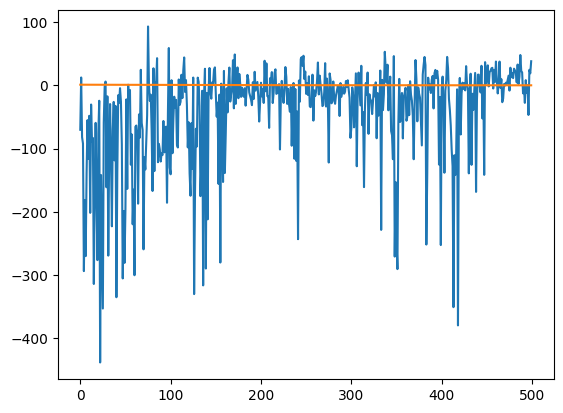

In [6]:
if __name__ == '__main__':
    env = gym.make('LunarLander-v2')
    agent = Agent(alpha=0.0005, gamma=0.99, n_actions=4,
                  epsilon=1.0, batch_size=64, input_dims=(8,))

    episodes = 500
    rewards = []
    epsilons = []
    max_step_per_episode = 100

    for episode in range(episodes):
        done = False
        reward = 0
        state, _ = env.reset()
        for i in range(max_step_per_episode):
            action = agent.Policy(state)
            new_state, reward_, done, info, _ = env.step(action)
            reward += reward_
            agent.AddToMemory(state, action, reward_, new_state, done)
            state = new_state
            agent.Learn()
            if done:
                break

        rewards.append(reward)
        epsilons.append(agent.epsilon)

        average_reward = np.mean(rewards[max(0, episode-100):(episode+1)])
        print('episode: ', episode, 'reward: ', reward,
              'average reward: ', average_reward)

        if episode % 10 == 0 and episode > 0:
            agent.save_model()

    plt.plot(rewards)
    plt.plot(epsilons)
    plt.show()